# Low-dimensional linear programming

*Note: this is a brief overview of this notebook. More project details are available [in the slides.](https://slides.com/parkerrule/low-dimensional-linear-programming/#/)

In this notebook, we study Megiddo's algorithm for linear programming in $\mathbb{R}^2$. This algorithm runs in $O(n)$ and thus has better asymptotic complexity properties than the widely used simplex method, which may run in exponential time in some cases. Because Megiddo's algorithm takes advantage of properties of the 2D Euclidean plane, it is arguably more interesting than the simplex method with respect to the techniques that we have learned this semester.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

## Linear programs
Recall that a *linear program* is a convex optimization problem in $n$ variables and $m$ constraints with the form

\begin{equation*}
\begin{array}{ll@{}ll} 
\text{minimize}  & \mathbf{c}^T \mathbf{x} \\
\text{subject to}& A \mathbf{x} \leq \mathbf{\beta}
\end{array}
\end{equation*}

where $c, x \in \mathbb{R}^n$, $A \in \mathbb{R}^{m \times n}$, and $\mathbf{\beta} \in \mathbb{R}^m$. For this notebook, we fix $n=2$.

Megiddo notes that we can apply a duality transformation and rewrite 2D linear programs such that the $y$-coordinate is minimized; thus, the coefficient of the objective is encoded in the constraints. In this notebook, we consider 2D linear programs of the form

\begin{equation*}
\begin{array}{ll@{}ll} 
\text{minimize}  & y \\
\text{subject to}& a_i x + b_i y \leq c_i \quad \forall i \in \{1, \dots, k\}
\end{array}
\end{equation*}

where $k$ is the number of constraints after the transformation.

In [2]:
def plot_2d_constraints(A, b, xmin=-10, xmax=10, ymin=-10, ymax=10, alpha=0.15, epsilon=1e-16):
    """Plots a set of 2D linear constraints in canonical LP form."""
    for (x_coeff, y_coeff), c in zip(A, b):
        xc = epsilon if x_coeff == 0 else x_coeff
        yc = epsilon if y_coeff == 0 else y_coeff
        m = -xc / yc
        b = c / yc
        x_range = [xmin, xmax]
        endpoints = [xmin * m + b, xmax * m + b]
        constraint = plt.plot(x_range, endpoints,
                              label='{:.1f}x + {:.1f}y ≤ {:.1f}'.format(x_coeff, y_coeff, c))
        if y_coeff > 0:
            plt.fill_between(x_range, endpoints, ymin, alpha=alpha)
        else:
            plt.fill_between(x_range, endpoints, ymax, alpha=alpha)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Here's an example set of constraints.

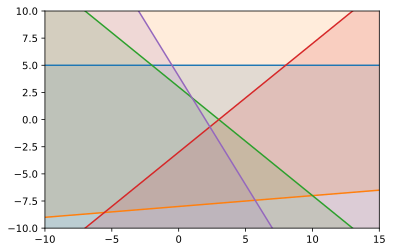

In [32]:
A1 = np.array([
    [0, 1],
    [0.1, -1],
    [1, 1],
    [-1, 1],
    [2, 1]
])
b1 = np.array([5, 8, 3, -3, 4])
plot_2d_constraints(A1, b1, xmax=15)

### Separating into $I_1$ and $I_2$

We convert constraints from standard form to point-slope form. We do not allow vertical constraints (bounds on x); these are passed as separate parameters to the algorithm. 

We then separate the constraints into $I_1$ (the "above" constraints) and $I_2$ (the "below constraints"). $I_1$ forms the lower part of the feasible region, if it exists; thus we seek to minimize $y$ on $I_1$.

In [4]:
def separate_constraints(A, b):
    """Separate y ≥ ax + b constraints (I1) from y ≤ ax + b constraints (I2)"""
    I1 = []
    I2 = []
    for (x_coeff, y_coeff), c in zip(A, b):
        if y_coeff < 0:
            I1.append((-x_coeff / y_coeff, c / y_coeff))
        elif y_coeff == 0:
            print('Skipping vertical constraint.')
        else:
            I2.append((-x_coeff / y_coeff, c / y_coeff))
    return I1, I2

### Brute force algorithm
We use the brute-force $O(n^3)$ algorithm when $n \leq 4$.

In [5]:
def brute_force(I1, I2, a, b):
    I = I1 + I2
    candidates = []
    points = []
    # Get intersections of constraints with each other.
    for outer_idx, (m_outer, b_outer) in enumerate(I):
        for (m_inner, b_inner) in I[outer_idx + 1:]:
            if m_outer == m_inner:
                continue
            x_inter = (b_inner - b_outer) / (m_outer - m_inner)
            if a <= x_inter <= b:
                y_inter = (m_outer * x_inter) + b_outer
                candidates.append((x_inter, y_inter))
    # Get intersection of constraints with x-bounds.
    for m_outer, b_outer in I:
        if a != float('-inf'):
            candidates.append((a, a * m_outer + b_outer))
        if b != float('inf'):
            candidates.append((b, b * m_outer + b_outer))
    
    for x_inter, y_inter in candidates:
        valid = True
        for m_check, b_check in I1:
            # "above" constraints
            if y_inter < m_check * x_inter + b_check:
                valid = False
                break
        if valid:
            for m_check, b_check in I2:
                # "below" constraints
                if y_inter > m_check * x_inter + b_check:
                    valid = False
                    break
        if valid:
            points.append((x_inter, y_inter))
    sorted_points = sorted(points, key=lambda p: p[1])
    if sorted_points:
        return {'status': 'optimal', 'value': sorted_points[0][0]}
    return {'status': 'infeasible', 'value': None}

### Megiddo's $O(n)$ algorithm
Megiddo's algorithm filters approximately $n/4$ constraints at each step. This can be done because the $x$-range is reduced at each step; we use the left and right derivatives of $g(x)$ (the "below" constraints) and $h(x)$ (the "above" constraints) to determine feasibility and decide how to narrow down the $x$-range.

In [6]:
def filter_constraints(I, a, b, above=True):
    I = I.copy()
    if len(I) == 1:
        return I, []
    if len(I) % 2 == 1:
            # Add a dummy redundant constraint to yield
            # an even number of constraints.
            I.append(I[-1])
            
    next_I = []
    x_vals = []
    for p_i, p_j in zip(I[::2], I[1::2]):
        a_i, b_i = p_i
        a_j, b_j = p_j
        if a_i == a_j:
            # For two constraints with the same slope,
            # drop the less restrictive constraint.
            if (b_i > b_j and above) or (b_j > b_i and not above):
                next_I.append((a_j, b_j))
            else:
                next_I.append((a_i, b_i))
            continue
        x_ij = (b_i - b_j) / (a_j - a_i)
        if x_ij <= a:
            # For the entirety of the search interval, the line with
            # smaller slope is more constraining. Drop the line with
            # larger slope.
            if (a_i > a_j and above) or (a_j > a_i and not above):
                next_I.append((a_i, b_i))
            else:
                next_I.append((a_j, b_j))
            continue
        elif x_ij >= b:
            # For the entirety of the search interval, the line with
            # larger slope is more constraining. Drop the line with
            # smaller slope.
            if (a_i < a_j and above) or (a_j < a_i and not above):
                next_I.append((a_i, b_i))
            else:
                next_I.append((a_j, b_j))
            continue
        else:
            x_vals.append(x_ij)
        # For some iterations, it may not be possible to remove
        # constraints.
        next_I.append((a_i, b_i))
        next_I.append((a_j, b_j))
    return next_I, x_vals

In [7]:
def megiddo(I1, I2, a, b, max_iters=100, epsilon=1e-8, debug=False):
    steps = [(None, a, b)]
    for _ in range(max_iters):
        I1, x_vals_above = filter_constraints(I1, a, b, above=True)
        I2, x_vals_below = filter_constraints(I2, a, b, above=False)        
        x_vals = x_vals_above + x_vals_below
        if not I1 or not I2 or not x_vals:
            # If we've eliminated so many constraints that we can
            # no longer get useful intersections, finish off the
            # problem with brute force!
            # Megiddo: "Of course, when the problem is small (e.g., n ≤ 4)
            # the problem will be solved directly."
            sol = brute_force(I1, I2, a, b)
            if sol['status'] == 'optimal':
                val = sol['value']
                steps.append((val, val, val))
            return {**sol, 'steps': steps}
            
            
        x_median = np.median(x_vals)
        steps.append((x_median, a, b))
        g_x = max(x_median * a_i + b_i for a_i, b_i in I1)
        h_x = min(x_median * a_i + b_i for a_i, b_i in I2)
        # One-sided derivatives.
        s_g = min(a_i for a_i, b_i in I1 if abs(x_median * a_i + b_i - g_x) < epsilon)
        S_g = max(a_i for a_i, b_i in I1 if abs(x_median * a_i + b_i - g_x) < epsilon)
        s_h = min(a_i for a_i, b_i in I2 if abs(x_median * a_i + b_i - h_x) < epsilon)
        S_h = max(a_i for a_i, b_i in I2 if abs(x_median * a_i + b_i - h_x) < epsilon)
        if debug:
            print('s_g:', s_g)
            print('S_g:', S_g)
            print('s_h:', s_h)
            print('S_h:', S_h)
            print('x:', x_median)
            print('g(x):', g_x)
            print('h(x):', h_x)
            print('a:', a)
            print('b:', b)
            print('|I1| + |I2|:', len(I1) + len(I2))
            print('---------')
        
        if g_x > h_x:
            # Case 1: x is currently infeasible.
            if s_g > S_h:
                # f(x) is ascending.
                # The feasible region lies to the left of x_median.
                b = x_median
            elif S_g > s_h:
                # f(x) is descending.
                # The feasible region lies to the right of x_median.
                a = x_median
            else:
                # The problem is known to be infeasible.
                break
        elif g_x < h_x:
            # Case 2: x is currently feasible and the height
            # of the feasible region at x is nonzero. Is x optimal?
            # ***NOTE***: The original Megiddo paper seems to have a
            # typo/inconsistency in it here. (it states that the conditions
            # for the first branch are s_g > 0 *or* S_g < 0).
            if s_g > 0:  
                # x is currently too big!
                b = x_median
            elif S_g < 0:
                # x is currently too small!
                a = x_median
            else:
                # We have found the optimal solution.
                return {'status': 'optimal', 'value': x_median, 'steps': steps}
        else:
            # Case 3: x is currently feasible and the height
            # of the feasible region at x is nonzero (that is, g_x == h_x).
            # Is x optimal?
            if s_g > 0 and s_g >= S_h:
                # x is currently too big!
                b = x_median
            elif S_g < 0 and S_g >= s_h:
                # x is currently too small!
                a = x_median
            else:
                # We have found the optimal solution.
                return {'status': 'optimal', 'value': x_median, 'steps': steps}
            
    if a == float('-inf') or b == float('inf'):
        return {'status': 'infeasible or unbounded', 'value': None, 'steps': steps}
    else:
        # It is possible to have a scenario where g(x) - h(x) is negatively
        # unbounded except by the initial x-bounds ([a, b]). The Megiddo
        # algorithm does not examine these endpoints when finding the median
        # x-value---it only considers intersection points. We can check the
        # endpoints explicitly if the problem is not x-unbounded.
        x_last = x_median
        g_x_last = max(x_last * a_i + b_i for a_i, b_i in I1) 
        for x in (a, b):
            g_x = max(x * a_i + b_i for a_i, b_i in I1)
            h_x = min(x * a_i + b_i for a_i, b_i in I2)
            if g_x <= h_x and g_x < g_x_last:
                x_last = x
                g_x_last = g_x
        if x_last != x_median:
            steps.append((x_last, x_last, x_last))
            return {'status': 'optimal', 'value': x, 'steps': steps}
    return {'status': 'infeasible', 'value': None, 'steps': steps}

## Viewing the solution
The `megiddo()` function saves intermediate steps for inspection. We can also visualize $g(x)$, $h(x)$, and the location of $x'$ at each step.

In [8]:
I1, I2 = separate_constraints(A1, b1)
solution_A1 = megiddo(I1, I2, -20, 20, debug=False)
solution_A1

{'status': 'optimal',
 'value': -5.555555555555555,
 'steps': [(None, -20, 20),
  (0.16666666666666674, -20, 20),
  (-2.0, -20, 0.16666666666666674),
  (-5.555555555555555, -5.555555555555555, -5.555555555555555)]}

In [9]:
def show_megiddo(steps, I1, I2, xmin=None, xmax=None):
    _, a_init, b_init = steps[0]
    if not xmin:
        xmin = a_init - 20
    if not xmax:
        xmax = b_init + 20
    step_values = [s[2] for s in steps]
    x_range = np.linspace(xmin, xmax, 100)
    if I1:
        g = [max(x * a_i + b_i for a_i, b_i in I1) for x in x_range]
    else:
        g = []
    if I2:
        h = [min(x * a_i + b_i for a_i, b_i in I2) for x in x_range]
    else:
        h = []
    for idx, step in enumerate(steps):
        value, a, b = step
        if g:
            plt.plot(x_range, g, color='red', label='g(x) [below]')
        if h:
            plt.plot(x_range, h, color='blue', label='h(x) [above]')
        if value is not None:
            plt.axvline(value, color='black', linestyle='--')
        plt.axvline(a, color='gray', linestyle=':')
        plt.axvline(b, color='gray', linestyle=':')
        plt.title(f'Step {idx}')
        plt.legend()
        plt.xlim(xmin, xmax)
        plt.show()

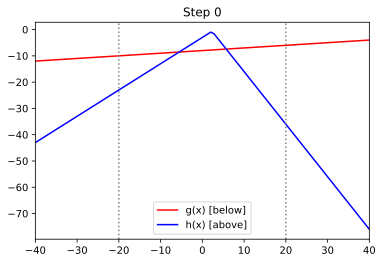

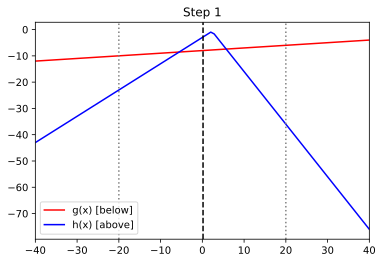

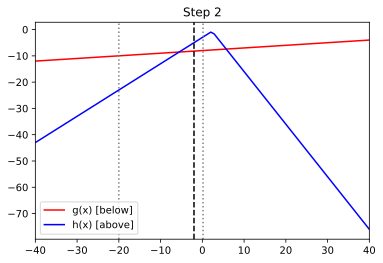

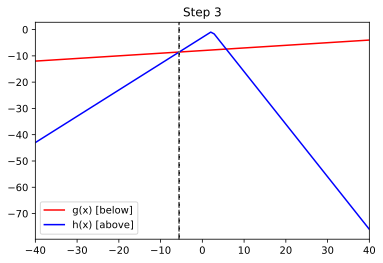

In [10]:
show_megiddo(solution_A1['steps'], I1, I2)

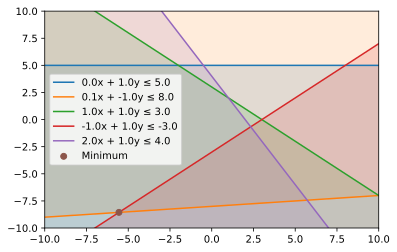

In [11]:
plot_2d_constraints(A1, b1)
y_A1 = max(solution_A1['value'] * a_i + b_i for a_i, b_i in I1)
plt.scatter([solution_A1['value']], [y_A1], zorder=5, label='Minimum')
plt.legend()
plt.show()

## Random constraints
To illustrate some of the cases that the solver encounters, we can sample constraints randomly. These constraints may or may not be feasible.

In [12]:
np.random.seed(1)
rand_size = 12

In [13]:
status = 'infeasible'
while status == 'infeasible':
    A_rand = 10 * np.random.random((rand_size, 2)) - 5
    b_rand = 10 * np.random.random(rand_size) - 5
    I1_rand, I2_rand = separate_constraints(A_rand, b_rand)
    solution_rand = megiddo(I1_rand, I2_rand, -20, 20, debug=False)
    status = solution_rand['status']

In [14]:
solution_rand = megiddo(I1_rand, I2_rand, -20, 20, debug=True)

s_g: -0.8665134953909779
S_g: -0.8665134953909779
s_h: -0.642257627509791
S_h: -0.642257627509791
x: 4.078433706819117
g(x): -2.516124606926729
h(x): -2.2096403500308606
a: -20
b: 20
|I1| + |I2|: 12
---------
s_g: -0.8665134953909779
S_g: -0.8665134953909779
s_h: -0.642257627509791
S_h: -0.642257627509791
x: 6.061674878061983
g(x): -4.2346298464236805
h(x): -3.483392119453043
a: 4.078433706819117
b: 20
|I1| + |I2|: 9
---------
s_g: -0.8665134953909779
S_g: -0.8665134953909779
s_h: -0.642257627509791
S_h: -0.642257627509791
x: 8.987227997554161
g(x): -6.7696611059468275
h(x): -5.362350925131957
a: 6.061674878061983
b: 20
|I1| + |I2|: 6
---------


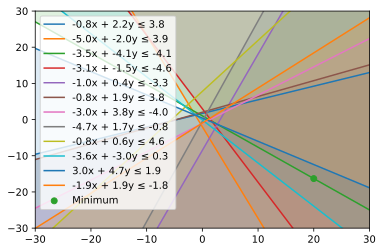

In [15]:
plot_2d_constraints(A_rand, b_rand, xmin=-30, xmax=30, ymin=-30, ymax=30)
if solution_rand['value'] is not None:
    y_rand = max(solution_rand['value'] * a_i + b_i for a_i, b_i in I1_rand)
    plt.scatter([solution_rand['value']], [y_rand], zorder=5, label='Minimum')
    plt.legend()
plt.show()

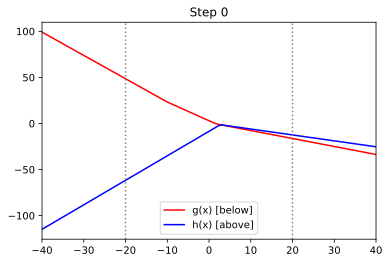

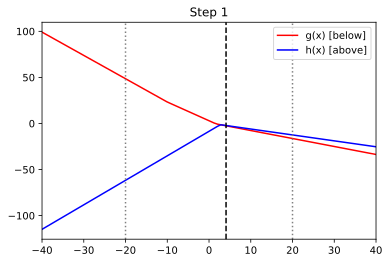

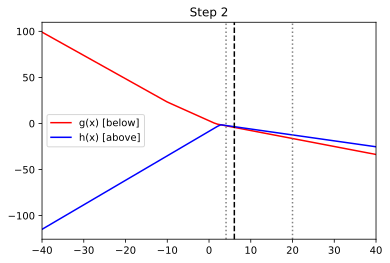

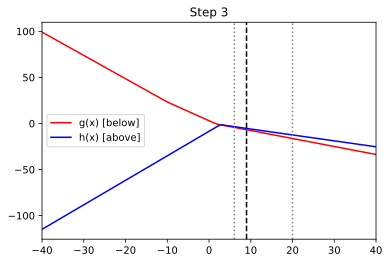

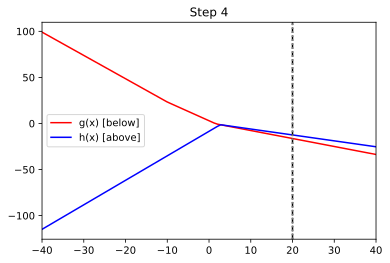

In [16]:
show_megiddo(solution_rand['steps'], I1_rand, I2_rand)

### References (primarily Megiddo-related)
Mount, David M. ["CMSC 754: Computational Geometry."](http://www.cs.umd.edu/class/spring2020/cmsc754/Lects/lect06-duality.pdf) Lecture Notes, University of Maryland (2020).

Shamos, Michael Ian. ["Computational geometry."](http://euro.ecom.cmu.edu/people/faculty/mshamos/1978ShamosThesis.pdf) Ph. D. thesis, Yale University (1978).

Souvaine, Diane L. ["Linear Programming in 2D."](http://www.cs.tufts.edu/comp/163/notes05/LP.pdf) Lecture Notes, Tufts University (2005).

Megiddo, Nimrod. ["Linear-time algorithms for linear programming in R^3 and related problems."](http://theory.stanford.edu/~megiddo/pdf/lp3.pdf) SIAM journal on computing 12.4 (1983): 759-776.

## Finding the intersection of half-planes with duality

Here we present an $O(n \log n)$ solution to the $\mathbb{R}^2$ linear programming problem. This approach is suggested by Shamos in his 1978 thesis. We construct the intersection of half-planes in $O(n \log n)$ time (Shamos uses divide-and-conquer; we use duality). We then inspect the vertices of the intersection of half-planes; there are at most $O(n)$ vertices by McMullen's upper bound theorem. One of these vertices yields the optimal solution.

We use the duality transform

\begin{align*}
    (a, b) \text{ in primal} \to y &= ax - b \text{ in dual} \\
    (c, -d) \text{ in dual} \to y &= cx + d \text{ in primal}
\end{align*}

to convert constraints to points. We take the lower convex hull of the "above" constraints of form $y \geq mx + b$ ($I_1$) and the upper convex hull of the "below" constriants of form $y \leq mx + b$ ($I_2$). The edges of these hulls yield intersection points that induce $g(x)$ and $h(x)$, respectively. The extreme points of the half-hulls map to rays in the primal that terminate $g(x)$ and $h(x)$. We call the representation of $g(x)$ defined by a left ray, a right ray, and a series of line segments in the middle the *lower envelope*; likewise, this representation of $h(x)$ is called the *upper envelope*

We implement the following:
* The 2D Graham scan algorithm for convex hulls
* A duality transform to find $g(x)$ and $h(x)$
* Truncation to convert envelopes to a series of line segments in the $x$-range $[a, b]$
* Intersection of envelopes to find the optimal $x$ or determine that the problem is infeasible

In [17]:
def left_turn(triple):
    a, b, c = triple
    return ((b[0] - a[0]) * (c[1] - a[1])) - ((b[1] - a[1]) * (c[0] - a[0])) > 0

def graham_scan_2d(points):
    """Finds the convex hull of a set of points in R^2 (general position assumed)."""
    if len(points) < 3:
        # TODO: sort here?
        return np.array(points)  
    
    # Compute the centroid of three arbitrary points.
    # Assumption: centroid not in points.
    centroid_x = points[:3, 0].sum() / 3
    centroid_y = points[:3, 1].sum() / 3
    
    def angle(p):
        x = p[0] - centroid_x
        y = p[1] - centroid_y
        theta = np.arctan(abs(y) / (abs(x) + 1e-8))
        if x >= 0 and y >= 0:
            return theta
        elif x <= 0 and y >= 0:
            return np.pi - theta
        elif x <= 0 and y <= 0:
            return np.pi + theta
        return (2 * np.pi) - theta
    
    points = np.array(sorted(points.tolist(), key=angle))

    # Find the leftmost point.
    leftmost_idx = np.argmin(points[:, 0])
    p_l = points[leftmost_idx].tolist()
    
    stack = deque()
    stack.append(p_l)
    
    def fix_stack():
        while (len(stack) > 2 and left_turn([stack[-1], stack[-2], stack[-3]])):
            top = stack.pop()
            removed = stack.pop()
            stack.append(top)
    
    for idx in range(points.shape[0] - 1):
        shifted_idx = (leftmost_idx + idx + 1) % points.shape[0]
        stack.append(points[shifted_idx])
        fix_stack()
    return np.array(stack)

In [18]:
def dual(points):
    points = np.array(points)
    points[:, 1] = -points[:, 1]
    return points

In [19]:
def half_envelope(hull, upper=True, epsilon=1e-8):
    if hull.size == 0:
        # Empty hull (no upper or lower constraints)
        return {}
    elif hull.shape[0] == 1:
        # One half-plane.
        plane = (hull[0][0], -hull[0][1])
        return {'left': plane, 'right': plane, 'points': []}

    p_min_x = min(hull, key=lambda p: p[0])
    p_max_x = max(hull, key=lambda p: p[0])
    m = (p_max_x[1] - p_min_x[1]) / (p_max_x[0] - p_min_x[0])
    b = p_max_x[1] - (m * p_max_x[0])
    
    if upper:
        # Use upper hull for upper envelope.
        hull = [p for p in hull if p[1] - (m * p[0] + b) >= -epsilon]
    else:
        # Use lower hull for lower envelope.
        hull = [p for p in hull if p[1] - (m * p[0] + b) <= epsilon]
    hull = sorted(hull, key=lambda p: p[0])
    
    envelope = []
    for idx, (p1, p2) in enumerate(zip(hull[:-1], hull[1:])):
        m = (p2[1] -  p1[1]) / (p2[0] -  p1[0])
        b = p2[1] - (m * p2[0])
        envelope.append((m, -b))
    envelope = sorted(envelope, key=lambda p: p[0])
    if upper:
        right = (hull[0][0], -hull[0][1])
        left = (hull[-1][0], -hull[-1][1])
    else:
        left = (hull[0][0], -hull[0][1])
        right = (hull[-1][0], -hull[-1][1])
    return {'left': left, 'right': right, 'points': envelope}

In [20]:
lower_envelope = half_envelope(graham_scan_2d(dual(I1)), upper=False)
upper_envelope = half_envelope(graham_scan_2d(dual(I2)), upper=True)

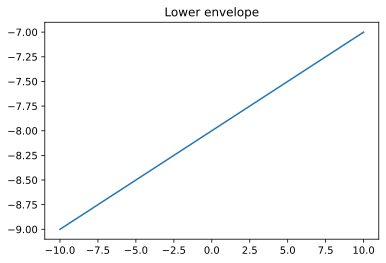

In [21]:
for m, b in I1:
    plt.plot([-10, 10], [-10 * m + b, 10 * m + b])
for x, y in lower_envelope['points']:
    plt.scatter([x], [y], zorder=5)
plt.title('Lower envelope')
plt.show()

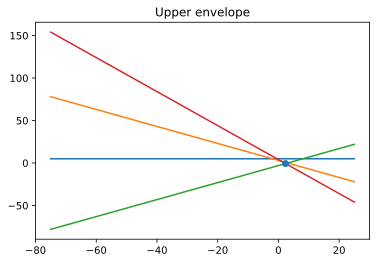

In [22]:
for m, b in I2:
    plt.plot([-75, 25], [-75 * m + b, 25 * m + b])
for x, y in upper_envelope['points']:
    plt.scatter([x], [y], zorder=5)
plt.title('Upper envelope')
plt.show()

In [23]:
upper_envelope

{'left': (1.0, -3.0),
 'right': (-2.0, 4.0),
 'points': [(2.3333333333333335, -0.6666666666666665)]}

In [24]:
lower_envelope

{'left': (0.1, -8.0), 'right': (0.1, -8.0), 'points': []}

In [25]:
def plot_half_envelope(envelope, xmin, xmax, *args, **kwargs):
    if envelope and not envelope['points']:
        m, b = envelope['left']
        plt.plot([xmin, xmax], [xmin * m + b, xmax * m + b], *args, **kwargs)
    elif envelope and envelope['points']:
        env_xmin = min(min([p[0] for p in envelope['points']]) - 1, xmin)
        env_xmax = max(max([p[0] for p in envelope['points']]) + 1, xmax)
        leftmost = (env_xmin, env_xmin * envelope['left'][0] + envelope['left'][1])
        rightmost = (env_xmax, env_xmax * envelope['right'][0] + envelope['right'][1])
        points = [leftmost, *envelope['points'], rightmost]
        print(points)
        plt.plot([p[0] for p in points], [p[1] for p in points],
                 *args, **kwargs)
    plt.xlim(xmin, xmax)

def plot_envelope(upper, lower, xmin=-10, xmax=10):
    plot_half_envelope(upper, xmin, xmax, color='blue', label='h(x) [above]', linewidth=2, marker='')
    plot_half_envelope(lower, xmin, xmax, color='red', label='g(x) [below]', linewidth=2, marker='')

[(-100, -103.0), (2.3333333333333335, -0.6666666666666665), (100, -196.0)]


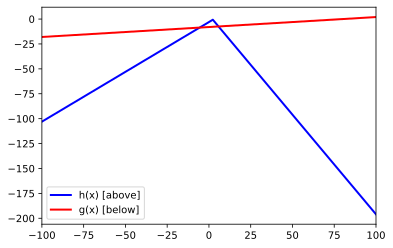

In [26]:
plot_envelope(upper_envelope, lower_envelope, xmin=-100, xmax=100)
plt.legend()
plt.show()

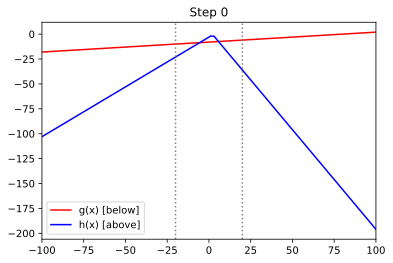

In [27]:
show_megiddo(solution_A1['steps'][:1], I1, I2, xmin=-100, xmax=100)

In [28]:
def truncate_envelope(envelope, a, b):
    """Truncates an envelope to the x-range [a, b]."""
    points = envelope['points']
    left = envelope['left']
    right = envelope['right']
    truncated = []
    if not points:
        # Case: single plane constraint.
        return [(a, left[0] * a + left[1]), (b, right[0] * b + right[1])]
    if envelope['points'][0][0] >= a:
        # Case: intersect with the left ray.
        truncated.append((a, left[0] * a + left[1]))
    else:
        # Case: filter edges until within range.
        last = points[0]
        for idx, p in enumerate(points[1:]):
            if p[0] >= a:
                segment_m = (p[1] - last[1]) / (p[0] - last[0])
                segment_b = p[1] - (segment_m * p[0])
                truncated.append((a, a * segment_m + segment_b))
                points = points[idx + 1:]
            last = p
    
    # Special case: only one point left.
    if points[0][0] >= b:
        truncated.append((b, right[0] * b + right[1]))
        return truncated
    elif a <= points[0][0] < b:
        truncated.append(points[0])
        
    last = points[0]
    for p in points[1:]:
        if a <= p[0] <= b and truncated[-1] != p:
            truncated.append(p)
        elif p[0] > b:
            segment_m = (p[1] - last[1]) / (p[0] - last[0])
            segment_b = p[1] - (segment_m * p[0])
            truncated.append((b, b * segment_m + segment_b))
            return truncated
    truncated.append((b, right[0] * b + right[1]))
    return truncated

In [29]:
def solve_lp(I1, I2, a, b):
    lower_envelope = half_envelope(graham_scan_2d(dual(I1)), upper=False)
    upper_envelope = half_envelope(graham_scan_2d(dual(I2)), upper=True)
    truncated_lower = truncate_envelope(lower_envelope, a, b)
    truncated_upper = truncate_envelope(upper_envelope, a, b)
    lower_idx = 0
    upper_idx = 0
    lower = truncated_lower[:2]
    upper = truncated_upper[:2]
    
    candidates = []
    for _ in range(len(truncated_lower) + len(truncated_upper) - 2):
        # Compute the intersction of the current upper and lower segments.
        lower_m = (lower[1][1] - lower[0][1]) / (lower[1][0] - lower[0][0])
        upper_m = (upper[1][1] - upper[0][1]) / (upper[1][0] - upper[0][0])
        lower_b = lower[0][1] - (lower_m * lower[0][0])
        upper_b = upper[0][1] - (upper_m * upper[0][0])
        x_inter = (lower_b - upper_b) / (upper_m - lower_m)
        y_inter = lower_m * x_inter + lower_b
        if (lower[0][0] <= x_inter <= lower[1][0] and
            upper[0][0] <= x_inter <= upper[1][0] and
            (not candidates or x_inter != candidates[-1][0])):
            candidates.append((x_inter, y_inter))
        
        if lower[1][0] < upper[1][0]:
            # Move to the next lower segment, if available.
            lower_idx += 1
            if lower_idx < len(truncated_lower) - 1:
                lower = truncated_lower[lower_idx:lower_idx + 2]
        else:
            # Move to the next upper segment, if available.
            upper_idx += 1
            if upper_idx < len(truncated_upper) - 1:
                upper = truncated_upper[upper_idx:upper_idx + 2]  
    
    if candidates:
        sol = min(candidates, key=lambda p: p[1])
        return {'status': 'optimal', 'value': sol[0]}, sol
    else:
        return {'status': 'infeasible', 'value': None}, None

In [30]:
_, (x_sol, y_sol) = solve_lp(I1, I2, -20, 20)

[(-10, -13.0), (2.3333333333333335, -0.6666666666666665), (10, -16.0)]


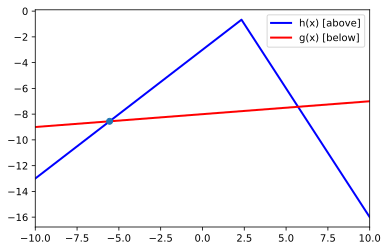

In [31]:
plot_envelope(upper_envelope, lower_envelope)
plt.scatter([x_sol], [y_sol], zorder=5)
plt.legend()
plt.show()

### References (primarily duality/convex hull-related)
Mount, David M. ["CMSC 754: Computational Geometry."](http://www.cs.umd.edu/class/spring2020/cmsc754/Lects/lect06-duality.pdf) Lecture Notes, University of Maryland (2020).

Sacristán, Vera. ["Intersecting half-planes and related problems."](https://dccg.upc.edu/people/vera/wp-content/uploads/2012/10/DAG-IntersectingHalfplanes.pdf)

Souvaine, Diane L. ["Finding Convex Hulls – part I."](http://www.cs.tufts.edu/comp/163/notes05/CH1_handout.pdf) Lecture Notes, Tufts University (2005).

I also referenced StackOverflow and Wikipedia for information related to Graham scan and for trivial computational questions.